# PanNuke.ipynb

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
import os
import sys
from pathlib import Path
from math import inf
from tqdm import tqdm

from torchvision.transforms import Compose, ToPILImage, ToTensor
import torch

top_folder = str(Path(os.getcwd()).parent.parent)
sys.path.append(top_folder)

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

%matplotlib widget

In [18]:
from src.vizualizations.image_viz import plot_images

In [19]:
fold_path = os.path.join(top_folder, 'data','raw','unzipped','PanNuke_orig')

## Inspecting Images

In [20]:
img_data = (np.load(os.path.join(fold_path, 'Fold 1','images','fold1','images.npy')))


In [21]:
img_data = img_data.astype(np.uint8)
print(img_data.dtype)
print(img_data[0].max(),img_data[1].min())
print(img_data.shape)

uint8
255 31
(2656, 256, 256, 3)


This is very intersting. The `.npy` says that it is 4GB large, but since each pixel is actually just 1 byte, the file should be closer to 500MB. It is my belief that pixels are stored as 8 byte floating points without actually making use of that extra precision. Hence, to save space, I will be converting all these images down to 8bits.

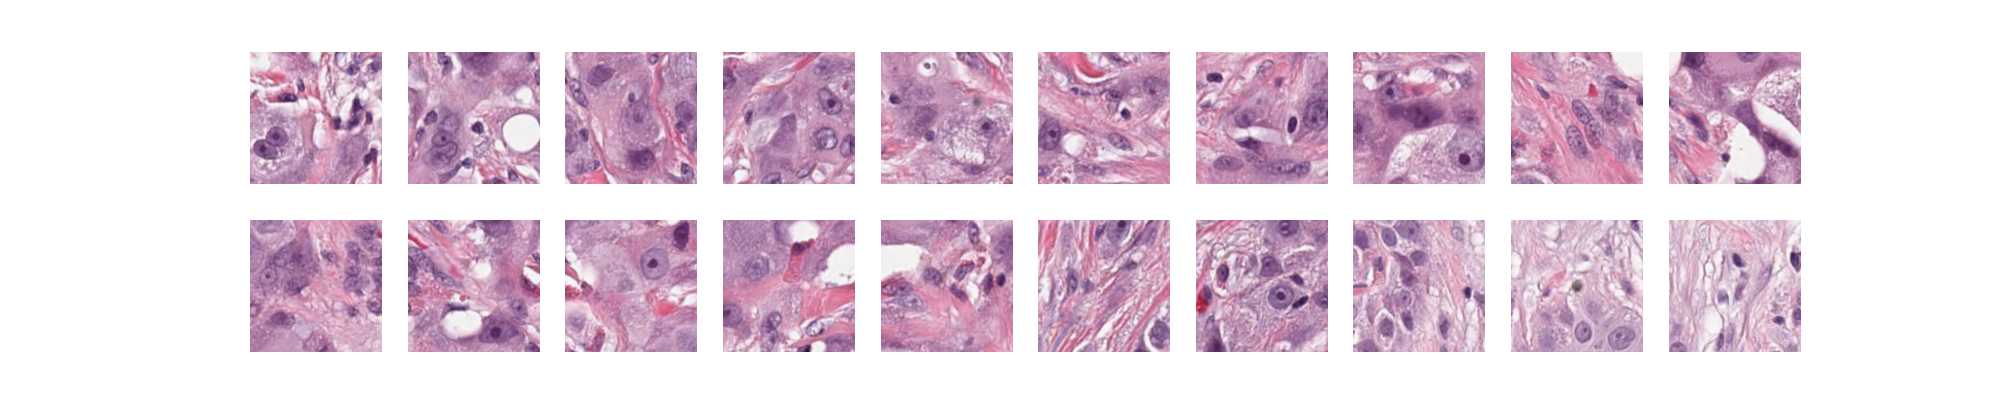

In [22]:
examples = img_data[:20]
plot_images(examples, (2,10))
plt.show()

In [23]:
del img_data

In [24]:
mask_data = (np.load(os.path.join(fold_path,'Fold 1','masks','fold1','masks.npy')))


In [25]:
mask_data = mask_data.astype(np.uint8)
print(mask_data.dtype)
print(mask_data[0].max(),mask_data[1].min())
print(mask_data.shape)

uint8
41 0
(2656, 256, 256, 6)


Interesting. Same mistake. There are 6 channels, 1 for the 5 types of cells recorded + 1 for background. Each value represents an instance id, and among all images in all folds, the max is less than 250 (241) so we can store safely this in a 6

uint8
0 159


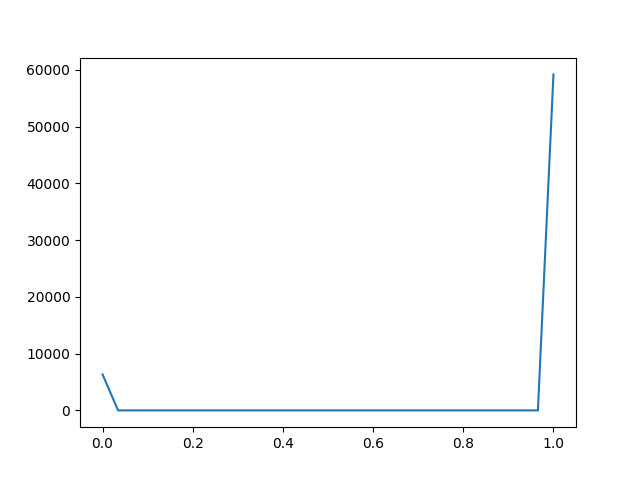

In [26]:
from src.vizualizations.tensor_viz import plot_tensor_histogram

sample = mask_data[:5,:,:,:].transpose(0,3,1,2)
print(sample.dtype)
sample = np.reshape(sample, (-1,256,256), order='C')

plot_tensor_histogram(sample[5], bins=30)
print(sample.min(), sample.max())
plt.show()



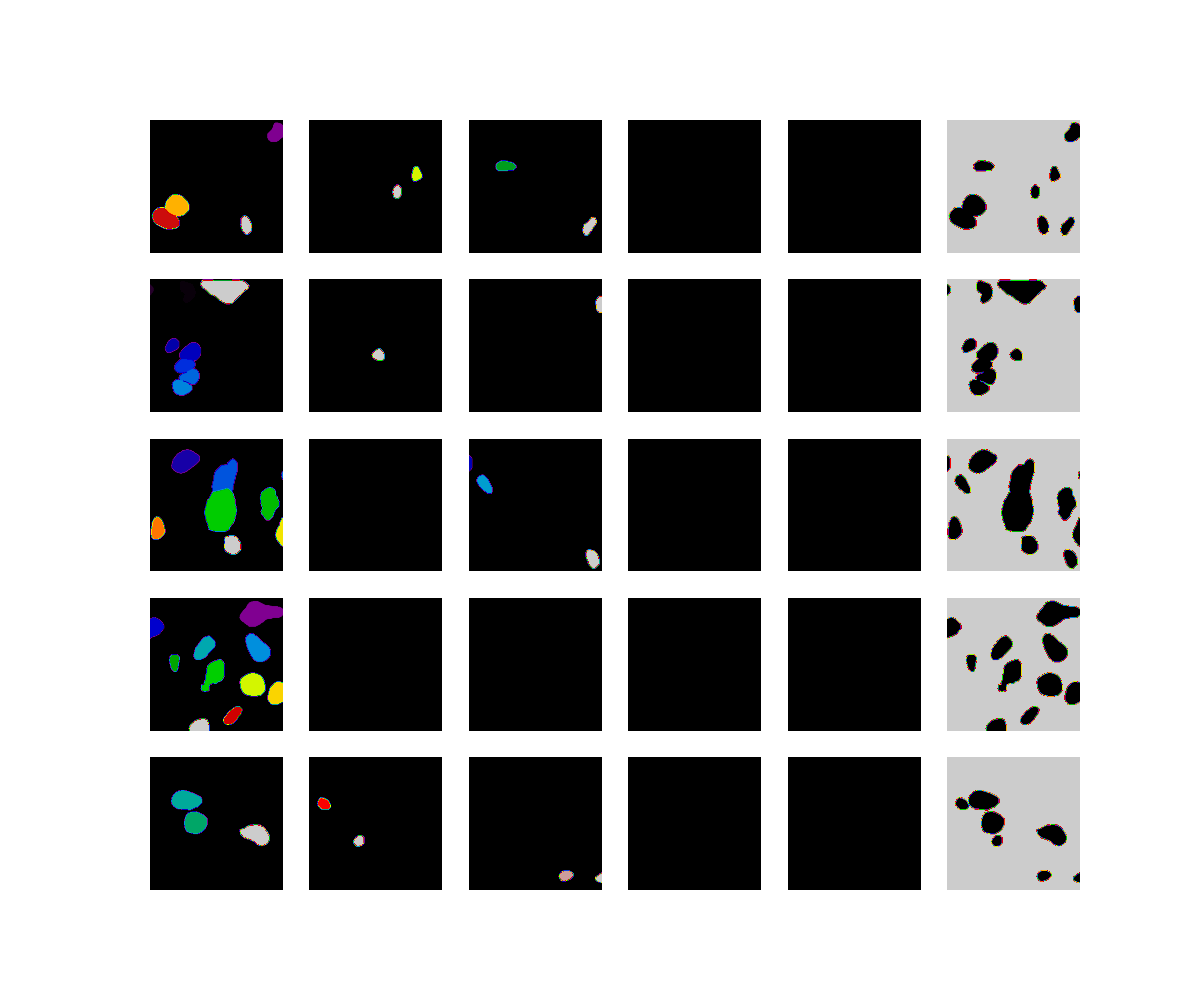

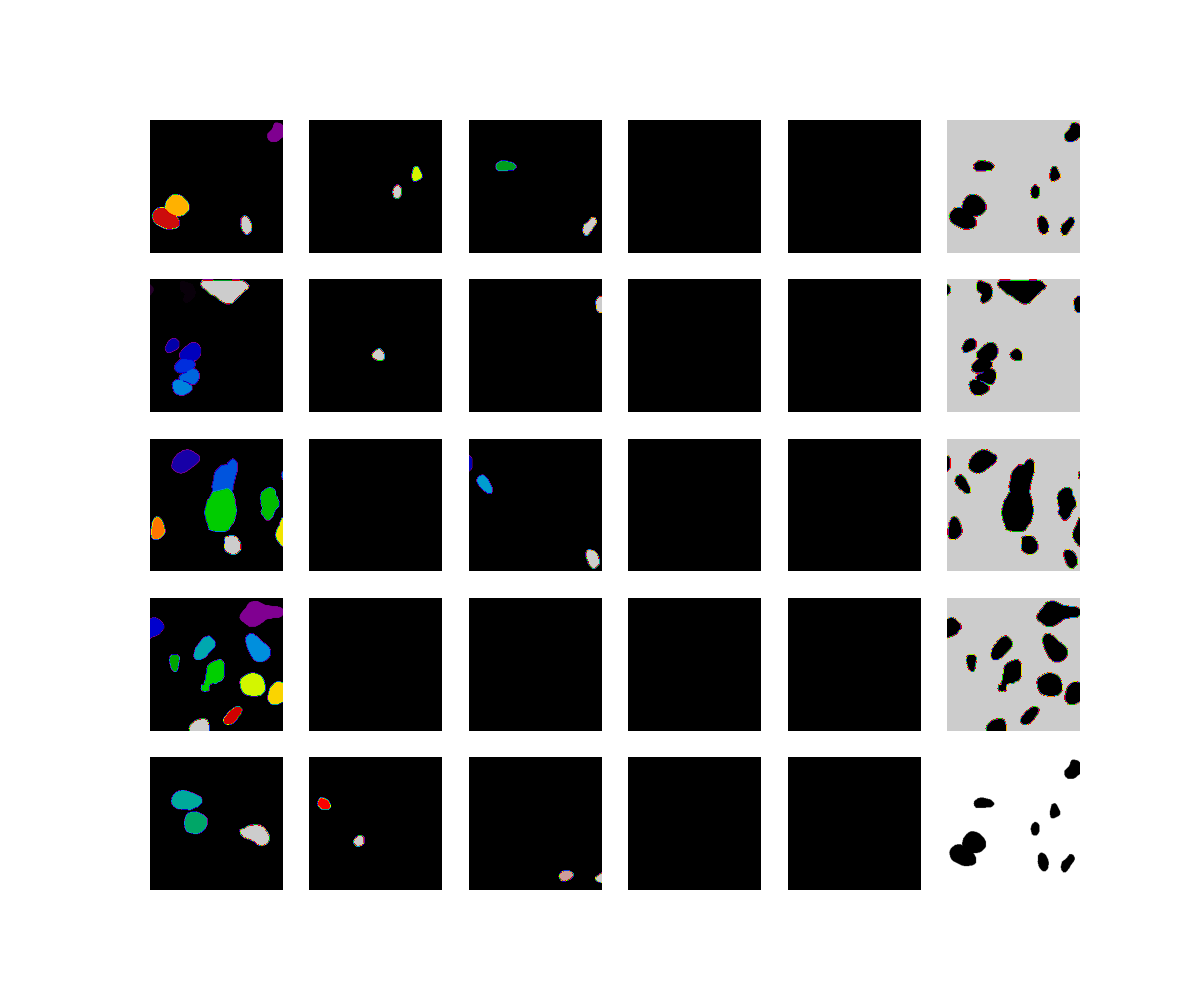

In [27]:
plot_images(sample,(5,6))
plt.show()
plt.imshow(sample[5],cmap="gray")
plt.show()

I was wrong. I do not think the last channel is for the background. Instead, I think it is for creating a mask for all the cell types. I shall process this last channel to derive the masks I am interested in. Also, the multi-colour effect is because of anti-aliasing I think. When you zoom in, they disappear. So actually, the image is just black and white, so can do simple **percolation algorithm**

In [28]:
#from src.utilities.os_utilities import create_dir_if_not_exist
#savefolder = os.path.join(top_folder,"tests","data","images")
#create_dir_if_not_exist(savefolder)
#np.save(os.path.join(savefolder,"test_island_identifier.npy"),sample[5])

## Problem
Doing percolation on the last channel seemed like a good idea, but because of overlaps, this causes **under-segmentation**. So instead, I will try to aggregate the first 5 channels which are well seperated.
Also, just to be safe, I shall use uint16 as there is a possibility that for super zoomed out images there may be more than 256 nuclei.

In [29]:
from src.utilities.tensor_utilties import map_value_numpy_array,map_values_numpy_array

def reorder_ids(img):
    ids = np.sort(np.unique(img)).tolist()
    new_ids = list(range(len(ids)))
    return map_values_numpy_array(img, ids, new_ids)

def aggregate_masks(mask):
    # 6 channel image (use first 5 channels)
    output = np.zeros((mask.shape[0],mask.shape[1]), dtype=np.uint16)
    for i in range(5):
        offset = output.max()
        addition = reorder_ids(mask[:,:,i])+offset
        addition = map_value_numpy_array(addition, offset, 0) # set background to 0
        output+=addition
   # assert output.max()<255
    return output.astype(np.uint16)
        


    
    

# Collect all images into 1 numpy file

In [30]:
def collect_images():
    fold_path = os.path.join(top_folder, 'data/raw/unzipped/PanNuke_orig')
    f1,f2,f3 = os.path.join(fold_path,"Fold 1","images","fold1","images.npy"),os.path.join(fold_path,"Fold 2","images","fold2","images.npy"),os.path.join(fold_path,"Fold 3","images","fold3","images.npy")
    a1 = np.load(f1).astype(np.uint8)
    a2 = np.load(f2).astype(np.uint8)
    a3 = np.load(f3).astype(np.uint8)
    arr = np.concatenate([a3,a2,a1],axis=0)
    print(arr.shape)
    np.save(os.path.join(fold_path,"images.npy"),arr)

def collect_masks(): 
    fold_path = os.path.join(top_folder, 'data/raw/unzipped/PanNuke_orig')
    f1,f2,f3 = os.path.join(fold_path,"Fold 1","masks","fold1","masks.npy"),os.path.join(fold_path,"Fold 2","masks","fold2","masks.npy"),os.path.join(fold_path,"Fold 3","masks","fold3","masks.npy")
    a1 = np.load(f1).astype(np.uint16)
    a2 = np.load(f2).astype(np.uint16)
    a3 = np.load(f3).astype(np.uint16)
    arr = np.concatenate([a3,a2,a1],axis=0)
    print(arr.shape)
    instance_mask = np.array([aggregate_masks(img) for img in tqdm(arr,desc="Generating Instance Masks")],dtype=np.uint16) 
    instance_mask = np.expand_dims(instance_mask,axis=3)
    semantic_mask = np.expand_dims( arr[:,:,:,5],axis=3)
    category_mask = (arr[:,:,:,:5]!=0).astype(np.uint8)
    print(instance_mask.shape)
    print(semantic_mask.shape)
    print(category_mask.shape)
    final = np.concatenate([category_mask,semantic_mask,instance_mask],axis=3)
    print(final.shape)
    #print(arr_island.max())
    #plot_tensor_histogram(arr_island, bins=30)
    #plt.show()
    np.save(os.path.join(fold_path,"masks.npy"),final)
    
#collect_images()
#collect_masks()


This turns each mask 6-tuple into a 7 tuple, where first 5 channels represent a one hot encoding of the pixel category (neo-plastic, etc), the penultimate channel is the instance segmentation mask, and the last channel is the semantic mask

In [34]:
fold_path = os.path.join(top_folder, 'data/processed/PanNuke')
imgs = np.load(os.path.join(fold_path,"images.npy"))
masks = np.load(os.path.join(fold_path,"masks.npy"))

# Breakdown of cell types

In [67]:
def count_cell_types(mask):
    counts = np.zeros(5)
    total = 0
    for i in range(len(mask)):
        ins_mask = np.expand_dims(mask[i,:,:,-1],axis=2)
        total+=np.max(ins_mask)
        additions = np.max(mask[i]*ins_mask,axis=(0,1))[:-1]
        assert len(additions)==5
        counts+=additions
    print(total)
    assert total ==counts.sum()
    return counts

count_breakdown = count_cell_types(masks)

194139


AssertionError: 

In [65]:
print(count_breakdown)
print(count_breakdown.sum())

[ 83007.  75334. 134392.  10692.  40885.]
344310.0


# Final
The images and masks are all stored within a numpy array